In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from itertools import combinations
from sklearn.impute import SimpleImputer

In [335]:
import seaborn as sns

# NOTE: WE NEED TO IMPUTE PER CLASS SO NO INFO LEAKS TO THE MINORITY

### The source code of the project. In this notebook the preprocessing is done using random oversampling and not the mix with SMOTE. The oversampling method can be changed in the code block for the preprocessing.

# Data preparation

In [336]:
train_data = pd.read_csv('aps_failure_training_set.csv')
test_data = pd.read_csv('aps_failure_test_set.csv')

In [337]:
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


##  [ag , ay , az , ba , cn , cs , ee]

In [338]:
'''bins = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'bin 6', 'bin 7', 'bin 8', 'bin 9', 'bin 10']

plt.bar(bins, height=X_vals[0], color='skyblue', edgecolor='black')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()'''

"bins = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'bin 6', 'bin 7', 'bin 8', 'bin 9', 'bin 10']\n\nplt.bar(bins, height=X_vals[0], color='skyblue', edgecolor='black')\nplt.xlabel('Bins')\nplt.ylabel('Frequency')\nplt.title('Histogram')\nplt.show()"

### plot

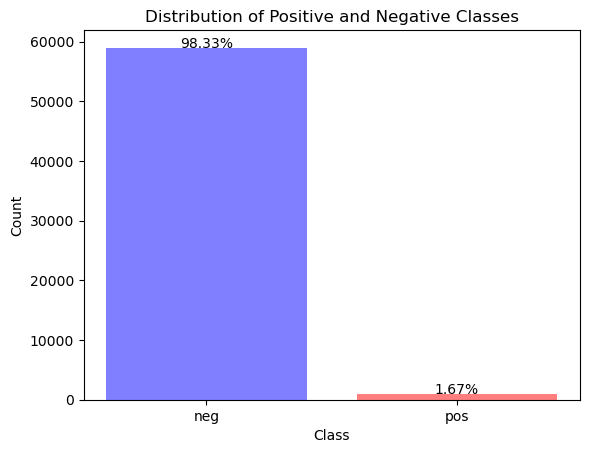

In [339]:
class_counts = train_data['class'].value_counts()

total_samples = len(train_data)
positive_percentage = (class_counts['pos'] / total_samples) * 100
negative_percentage = (class_counts['neg'] / total_samples) * 100

# Plotting
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'], alpha=0.5)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Classes')
plt.text(1, class_counts['pos'], f'{positive_percentage:.2f}%', ha='center')
plt.text(0, class_counts['neg'], f'{negative_percentage:.2f}%', ha='center')
plt.show()

### plot

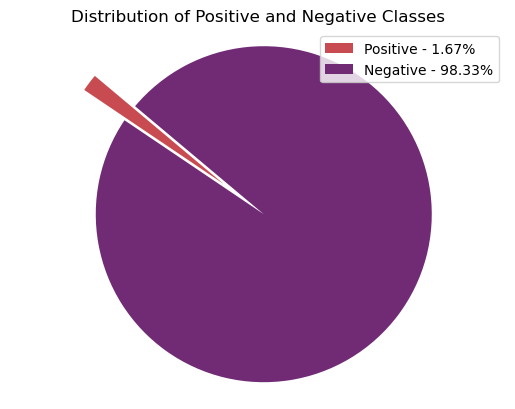

In [340]:
# Plotting
labels = ['Positive - 1.67%', 'Negative - 98.33%']
sizes = [positive_percentage, negative_percentage]
colors = ['#C74B50', '#712B75']
explode = (0.3, 0)  # explode the 1st slice (Positive)

patches, texts = plt.pie(sizes, explode=explode, colors=colors, shadow=False, startangle=140, wedgeprops = {"linewidth": 0, "edgecolor": "white"})
plt.axis('equal')
plt.title('Distribution of Positive and Negative Classes')
plt.legend(labels=labels)
plt.show()

In [341]:
'''hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']
data_point = 50576
X_vals_pos = [] # rows are the values in the bins, each row is a feature. 
for feat in range(len(hist_feat_names)):
    bin_vals = []
    for hist in range(10):
        curr_hist = hist_feat_names[feat] + '_00' + str(hist)
        value = train_data.iloc[50576][curr_hist]
        bin_vals.append(float(value))
    X_vals_pos.append(bin_vals)


#plot
fig, axs = plt.subplots(1, len(hist_feat_names), figsize=(20, 5))
for i, feat_name in enumerate(hist_feat_names):
    axs[i].bar(bins, height=X_vals_pos[i], color='skyblue', edgecolor='black');
    axs[i].set_xlabel('Bins')
    axs[i].set_xticklabels(bins, rotation=90)
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram for {feat_name}')

plt.tight_layout()
plt.show();'''

"hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']\ndata_point = 50576\nX_vals_pos = [] # rows are the values in the bins, each row is a feature. \nfor feat in range(len(hist_feat_names)):\n    bin_vals = []\n    for hist in range(10):\n        curr_hist = hist_feat_names[feat] + '_00' + str(hist)\n        value = train_data.iloc[50576][curr_hist]\n        bin_vals.append(float(value))\n    X_vals_pos.append(bin_vals)\n\n\n#plot\nfig, axs = plt.subplots(1, len(hist_feat_names), figsize=(20, 5))\nfor i, feat_name in enumerate(hist_feat_names):\n    axs[i].bar(bins, height=X_vals_pos[i], color='skyblue', edgecolor='black');\n    axs[i].set_xlabel('Bins')\n    axs[i].set_xticklabels(bins, rotation=90)\n    axs[i].set_ylabel('Frequency')\n    axs[i].set_title(f'Histogram for {feat_name}')\n\nplt.tight_layout()\nplt.show();"

neg -> 0

pos -> 1 : trucks with a problem

In [342]:
train_data = train_data.apply(pd.to_numeric, errors='ignore');
test_data = test_data.apply(pd.to_numeric, errors='ignore');

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_4524/1030849399.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  train_data = train_data.apply(pd.to_numeric, errors='ignore');
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_4524/1030849399.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  test_data = test_data.apply(pd.to_numeric, errors='ignore');


In [343]:
print(train_data)

      class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg   76698     na  2130706438    280      0      0      0      0   
1       neg   33058     na           0     na      0      0      0      0   
2       neg   41040     na         228    100      0      0      0      0   
3       neg      12      0          70     66      0     10      0      0   
4       neg   60874     na        1368    458      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995   neg  153002     na         664    186      0      0      0      0   
59996   neg    2286     na  2130706538    224      0      0      0      0   
59997   neg     112      0  2130706432     18      0      0      0      0   
59998   neg   80292     na  2130706432    494      0      0      0      0   
59999   neg   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  ee_007  ee_0

In [344]:
print(test_data)

      class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg      60      0          20     12      0      0      0      0   
1       neg      82      0          68     40      0      0      0      0   
2       neg   66002      2         212    112      0      0      0      0   
3       neg   59816     na        1010    936      0      0      0      0   
4       neg    1814     na         156    140      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
15995   neg   81852     na  2130706432    892      0      0      0      0   
15996   neg      18      0          52     46      8     26      0      0   
15997   neg   79636     na        1670   1518      0      0      0      0   
15998   neg     110     na          36     32      0      0      0      0   
15999   neg       8      0           6      4      2      2      0      0   

      ag_002  ...  ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 

In [345]:
train_data['class'] = train_data['class'].map({'neg': 0, 'pos': 1})
test_data['class'] = test_data['class'].map({'neg': 0, 'pos': 1})

In [346]:
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,0,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,0,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,0,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [347]:
    
def plot_hist_feat(which: str):
    hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']
    print('Plotting histogram for ', which)
    feat = hist_feat_names.index(which)

    data_points = [] # get some from both classes to compare

    for i in range(20): # get 20 samples from each class
        data_points.append(train_data[train_data['class'] == 0.0][i:i+1].index[0])
    
    for j in range(20): # get 20 samples from positive
        data_points.append(train_data[train_data['class'] == 1.0][j:j+1].index[0])
    

    print(len(data_points))
    
    histograms = []
    

    for data_point in data_points:

        X_vals = [] # rows are the values in the bins, each row is a feature

        bin_vals = []
        for hist in range(10):
            curr_hist = hist_feat_names[feat] + '_00' + str(hist)
            try:
                value = train_data.iloc[data_point][curr_hist]
            except:
                print('Out of bins for histogram feature ', hist_feat_names[feat])
                continue
            
            try:
                bin_vals.append(float(value))
            except:
                print('value for histogram feature ', hist_feat_names[feat],' was na. Using 0.')
                bin_vals.append(0)
            
        X_vals.append(bin_vals)

        histograms.append(X_vals)


    x = np.linspace(0,10,10)

    ind = 0
    for data_point in data_points:  #plot the histogram lines for each data point
        y = []
        for i in range(len(x)):
            try:
                y.append(float(histograms[data_point][0][i]))
            except IndexError:
                y.append(0)
        
        if ind<20:
            plt.plot(x,y, label="neg", color="green")
        else:
            plt.plot(x,y, label="pos", color="red")

        ind += 1
    
    # Show the plot
    plt.legend()
    plt.show()

Plotting histogram for  ag
40


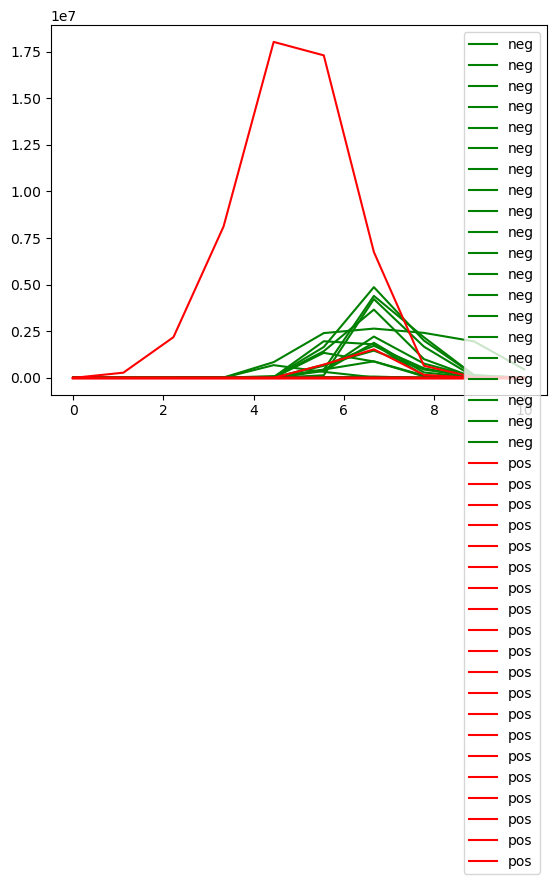

In [348]:
plot_hist_feat('ag')

## showing missing values

In [349]:
print(train_data)

       class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0          0   76698     na  2130706438    280      0      0      0      0   
1          0   33058     na           0     na      0      0      0      0   
2          0   41040     na         228    100      0      0      0      0   
3          0      12      0          70     66      0     10      0      0   
4          0   60874     na        1368    458      0      0      0      0   
...      ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995      0  153002     na         664    186      0      0      0      0   
59996      0    2286     na  2130706538    224      0      0      0      0   
59997      0     112      0  2130706432     18      0      0      0      0   
59998      0   80292     na  2130706432    494      0      0      0      0   
59999      0   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  

In [350]:
# replace 'na' with np.nan float
train_data.replace('na', np.nan, inplace=True)
test_data.replace('na', np.nan, inplace=True) 

na_counts = train_data.isna().sum()

# drop the features that have too many NA values (more than 35,000)
bad_features = na_counts[na_counts > 35000].index
train_data = train_data.drop(columns=bad_features)
test_data = test_data.drop(columns=bad_features)

# impute
positive_train = train_data[train_data['class'] == 1]
negative_train = train_data[train_data['class'] == 0]

imputer_pos = SimpleImputer(strategy='median')
imputer_neg = SimpleImputer(strategy='median')

# Fit the imputer on the DataFrame and transform the data
positive_train = pd.DataFrame(imputer_pos.fit_transform(positive_train), columns=train_data.columns)
negative_train = pd.DataFrame(imputer_neg.fit_transform(negative_train), columns=train_data.columns)

train_data = pd.concat([positive_train, negative_train])
train_data.reset_index(drop=True, inplace=True)
#==========

# impute
positive_test = test_data[test_data['class'] == 1]
negative_test = test_data[test_data['class'] == 0]

# Fit the imputer on the DataFrame and transform the data
positive_test = pd.DataFrame(imputer_pos.transform(positive_test), columns=train_data.columns)
negative_test = pd.DataFrame(imputer_neg.transform(negative_test), columns=train_data.columns)


test_data = pd.concat([positive_test, negative_test])
test_data.reset_index(drop=True, inplace=True)


In [351]:
train_data

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1.0,153204.0,1.820000e+02,648.0,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,1.0,453236.0,2.926000e+03,648.0,0.0,0.0,0.0,0.0,222.0,323436.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,1.0,72504.0,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,1.0,762958.0,8.650000e+02,648.0,0.0,0.0,776.0,281128.0,2186308.0,8123016.0,...,2949986.0,1295384.0,2591636.0,2717748.0,2185156.0,911552.0,64248.0,8.0,0.0,0.0
4,1.0,695994.0,8.650000e+02,648.0,0.0,0.0,0.0,0.0,0.0,55620.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,153002.0,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0.0,2286.0,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,112.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0.0,80292.0,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [352]:
test_data

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1.0,1800546.0,8.650000e+02,13042.0,0.0,0.0,0.0,280.0,132164.0,7875494.0,...,30997662.0,7611880.0,9706814.0,7087194.0,24679144.0,121822.0,52624.0,0.0,0.0,0.0
1,1.0,715316.0,8.650000e+02,648.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3905674.0,1753622.0,3247762.0,2700712.0,2902338.0,2787064.0,3187202.0,135060.0,0.0,0.0
2,1.0,1055714.0,8.650000e+02,648.0,0.0,0.0,0.0,0.0,0.0,130.0,...,7651830.0,3968726.0,9587618.0,8521170.0,6513690.0,3988408.0,6064958.0,307808.0,0.0,0.0
3,1.0,27304.0,5.120000e+02,486.0,0.0,0.0,0.0,0.0,0.0,576480.0,...,241924.0,99820.0,216566.0,203724.0,226244.0,170430.0,7472.0,0.0,0.0,0.0
4,1.0,1520540.0,8.650000e+02,648.0,0.0,0.0,0.0,0.0,0.0,60.0,...,12830228.0,7287542.0,21196940.0,12907126.0,7005504.0,3584098.0,4639484.0,113974.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,81852.0,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,0.0,18.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,0.0,79636.0,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,0.0,110.0,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [353]:
import pipelines as pipe

## Histogram feature extraction

In [354]:
    
def plot_hist_feat(which: str):
    hist_feat_names = ['ag' , 'ay' , 'az' , 'ba' , 'cn' , 'cs' , 'ee']
    print('Plotting histogram for ', which)
    feat = hist_feat_names.index(which)

    data_points = [] # get some from both classes to compare

    #for i in range(20): # get 20 samples from each class
        #data_points.append(train_data[train_data['class'] == 0.0][i+10:i+1+10].index[0])
    
    for j in range(20): # get 20 samples from positive
        data_points.append(train_data[train_data['class'] == 1.0][j:j+1].index[0])
    

    print(len(data_points))
    
    histograms = []
    

    for data_point in data_points:

        X_vals = [] # rows are the values in the bins, each row is a feature

        bin_vals = []
        for hist in range(10):
            curr_hist = hist_feat_names[feat] + '_00' + str(hist)
            try:
                value = train_data.iloc[data_point][curr_hist]
            except:
                print('Out of bins for histogram feature ', hist_feat_names[feat])
                continue
            
            try:
                bin_vals.append(float(value))
            except:
                print('value for histogram feature ', hist_feat_names[feat],' was na. Using 0.')
                bin_vals.append(0)
            
        X_vals.append(bin_vals)

        histograms.append(X_vals)


    x = np.linspace(0,10,10)

    ind = 0
    for data_point in data_points:  #plot the histogram lines for each data point
        y = []
        for i in range(len(x)):
            try:
                y.append(float(histograms[data_point][0][i]))
            except IndexError:
                y.append(0)
        
        '''if ind<20:
            plt.plot(x,y, label="neg", color="green")
        else:
            plt.plot(x,y, label="pos", color="red")'''
        plt.plot(x,y)

        ind += 1
    
    # Show the plot
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting histogram for  ag
20


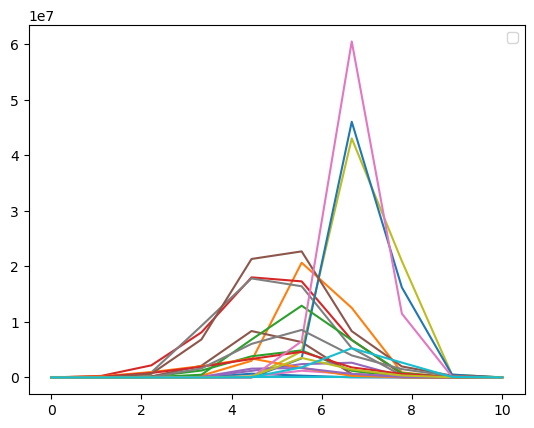

In [355]:
plot_hist_feat('ag')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting histogram for  az
20


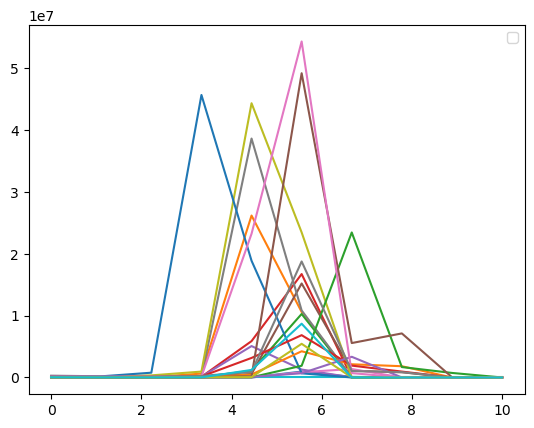

In [356]:
plot_hist_feat('az')

Plotting histogram for  cn


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20


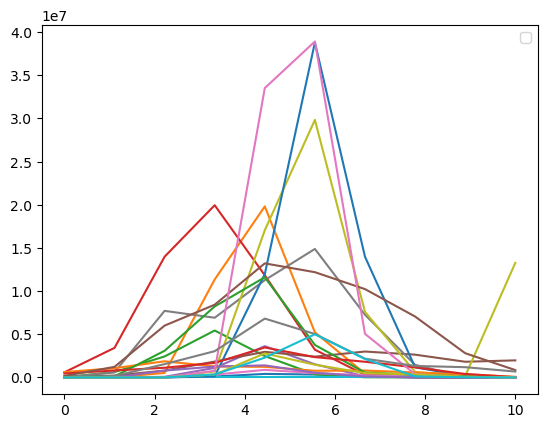

In [357]:
plot_hist_feat('cn')

Plotting histogram for  cs
20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


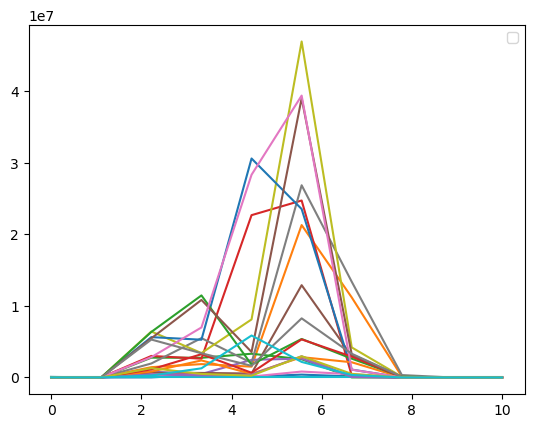

In [358]:
plot_hist_feat('cs')

In [359]:
train_data

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,1.0,153204.0,1.820000e+02,648.0,0.0,0.0,0.0,0.0,0.0,11804.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,1.0,453236.0,2.926000e+03,648.0,0.0,0.0,0.0,0.0,222.0,323436.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,1.0,72504.0,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,1.0,762958.0,8.650000e+02,648.0,0.0,0.0,776.0,281128.0,2186308.0,8123016.0,...,2949986.0,1295384.0,2591636.0,2717748.0,2185156.0,911552.0,64248.0,8.0,0.0,0.0
4,1.0,695994.0,8.650000e+02,648.0,0.0,0.0,0.0,0.0,0.0,55620.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,153002.0,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0.0,2286.0,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,112.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0.0,80292.0,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [360]:
class_counts = train_data['class'].value_counts()

print(class_counts)

class
0.0    59000
1.0     1000
Name: count, dtype: int64


In [361]:
x_train = train_data.drop(['class'], axis=1)
x_test = test_data.drop(['class'], axis=1)

y_train = train_data['class'].astype(int)
y_test = test_data['class'].astype(int)

# From here we use pipelines

In [362]:
x_train, x_test, y_train, y_test = pipe.pipeline(x_train, x_test, y_train, y_test,
                                                scaler='standard',
                                                imputer='pass',
                                                oversampling='random',
                                                VIF='no')
x_train[0]

array([ 6.45453113e-01, -4.32858719e-01, -4.07463580e-03, -4.13224252e-02,
       -5.13580802e-02, -1.07622955e-02, -2.83695832e-02, -5.69299196e-02,
       -1.00094894e-01,  1.06688322e-01, -2.37768336e-01, -4.16066155e-01,
       -3.49754818e-01, -1.60737781e-01, -2.99784625e-02,  2.02181598e-01,
        3.33470269e-02, -2.25908920e-02, -1.24340521e-02, -5.50407488e-02,
       -5.52124620e-02,  2.69506630e-01,  2.08272838e-01,  1.83673672e-01,
        5.37531728e-01,  2.83254932e-01, -1.14505864e-02, -4.21798742e-02,
       -1.45175435e-02,  4.23389689e-02,  3.42105654e-01, -2.67179846e-02,
       -1.89306909e-02, -2.54787933e-02, -3.48009464e-02, -2.96278176e-02,
       -7.98431865e-02, -3.27529690e-01, -2.83267383e-01, -2.03452401e-02,
       -1.18017734e-02, -1.02950181e-01, -1.29116638e-01, -7.50812233e-02,
       -1.32633906e-01, -3.51050152e-01, -1.81651567e-01, -1.07244383e-02,
       -2.03369352e-02, -4.40927582e-02, -1.28472127e-02, -1.83368484e-01,
       -3.01276148e-01, -

In [363]:
x_train.shape

(118000, 162)

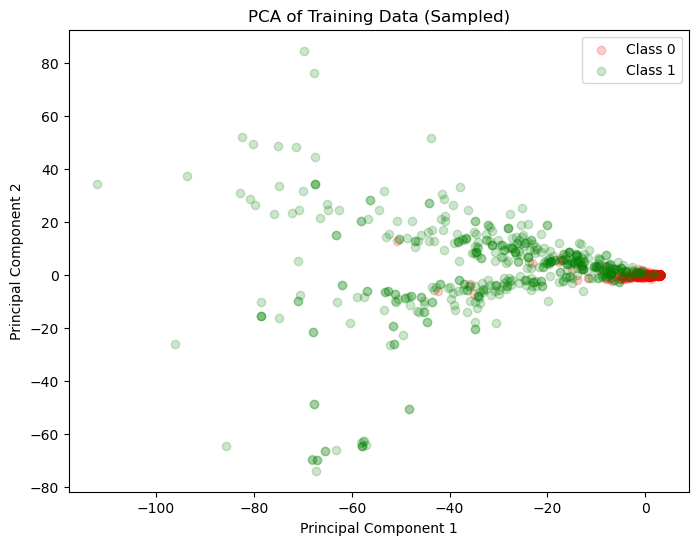

In [364]:
# sample 1000 data points
random_indices = np.random.choice(x_train.shape[0], size=1000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

# covariance matrix
cov_matrix = np.cov(x_train_sampled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 2
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

# Plot
plt.figure(figsize=(8, 6))
classes = np.unique(y_train_sampled)
colors = ['r', 'g']

for cls, color in zip(classes, colors):
    idx = np.where(y_train_sampled == cls)
    plt.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], c=color, label=f'Class {cls}', alpha=0.2)

plt.title('PCA of Training Data (Sampled)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


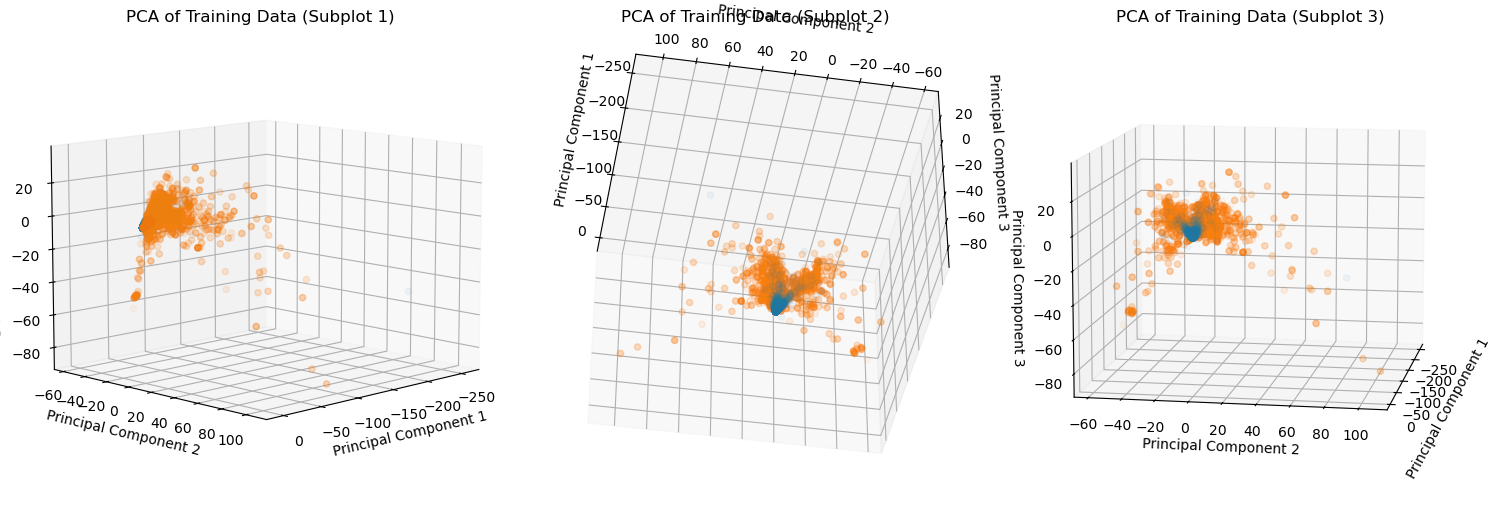

In [365]:
# pca
random_indices = np.random.choice(x_train.shape[0], size=10000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

cov_matrix = np.cov(x_train_sampled, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 3
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

#plot
fig = plt.figure(figsize=(15, 5))
angles = [(10, 45), (-40, 170), (10, 10)]
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.set_title(f'PCA of Training Data (Subplot {i+1})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    for cls in np.unique(y_train_sampled):
        idx = np.where(y_train_sampled == cls)
        ax.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], x_train_pca[idx, 2], label=f'Class {cls}', alpha=0.05)
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

# san cone, ta negatives einai mazemena sti myth


# Testing models

## Neural 

In [366]:
'''
m = tf.keras.metrics.FalseNegatives()
rec = tf.keras.metrics.Recall()
# to categorical
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# model
model = Sequential([
    Dense(64, input_dim=x_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[m,rec,'accuracy'])
model.fit(x_train, y_train_encoded, epochs=200, batch_size=32, validation_split=0.2)
'''

"\nm = tf.keras.metrics.FalseNegatives()\nrec = tf.keras.metrics.Recall()\n# to categorical\nnum_classes = len(np.unique(y_train))\ny_train_encoded = to_categorical(y_train, num_classes)\ny_test_encoded = to_categorical(y_test, num_classes)\n\n# model\nmodel = Sequential([\n    Dense(64, input_dim=x_train.shape[1], activation='relu'),\n    Dense(64, activation='relu'),\n    Dense(num_classes, activation='softmax')\n])\n\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[m,rec,'accuracy'])\nmodel.fit(x_train, y_train_encoded, epochs=200, batch_size=32, validation_split=0.2)\n"

In [367]:
'''y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1}')

conf_m = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_m)

tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)
print(f'Test Cost: {cost}')'''

"y_pred_probs = model.predict(x_test)\ny_pred = np.argmax(y_pred_probs, axis=1)\n\nmacro_f1 = f1_score(y_test, y_pred, average='macro')\nprint(f'Macro F1 Score: {macro_f1}')\n\nconf_m = confusion_matrix(y_test, y_pred)\nprint('Confusion Matrix:')\nprint(conf_m)\n\ntn, fp, fn, tp = conf_m.ravel()\ncost = (10 * fp) + (500 * fn)\nprint(f'Test Cost: {cost}')"

In [368]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
import numpy as np

## making a scorer

In [369]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [370]:
def custom_scoring_function(y_true, y_pred):
    conf_m = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_m.ravel()
    cost = (10 * fp) + (500 * fn)
    return cost

scorer = make_scorer(custom_scoring_function, greater_is_better=False)

## Random Forest

In [371]:
'''
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [5], #[3,5,7,9]
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
'''

'\nrf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)\n\n# hp tuning\nparam_grid = {\n    \'max_depth\': [5], #[3,5,7,9]\n    \'n_estimators\': [22] #[10,20,22,50]\n}\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'f1_macro\', cv=5)\ngrid_search.fit(x_train, y_train)\n\n# calculations\ny_pred = grid_search.predict(x_test)\nconf_m = confusion_matrix(y_test, y_pred)\ntn, fp, fn, tp = conf_m.ravel()\ncost = (10 * fp) + (500 * fn)\n\n# output\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best score found:", grid_search.best_score_)\nprint(f\' macro f1 = {f1_score(y_test, y_pred, average="macro")}\')\nprint("Test Cost : ", cost)\nprint(conf_m)\n\n# ROC\n\n# calculate roc curves\nprint(y_pred.shape)\nprint(y_test.shape)\nfpr, tpr, thresholds = roc_curve(y_test, y_pred)\n\n# plot the roc curve\nplt.plot([0,1], [0,1], linestyle=\'--\', label=\'\')\nplt.plot(fpr, tpr, marker=\'.\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True

In [372]:
'''rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [3,5,7,9],
    'n_estimators': [20,22,50] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()'''

'rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)\n\n# hp tuning\nparam_grid = {\n    \'max_depth\': [3,5,7,9],\n    \'n_estimators\': [20,22,50] #[10,20,22,50]\n}\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'f1_macro\' , cv=5)\ngrid_search.fit(x_train, y_train)\n\n# calculations\ny_pred = grid_search.predict(x_test)\nconf_m = confusion_matrix(y_test, y_pred)\ntn, fp, fn, tp = conf_m.ravel()\ncost = (10 * fp) + (500 * fn)\n\n# output\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best score found:", grid_search.best_score_)\nprint(f\' macro f1 = {f1_score(y_test, y_pred, average="macro")}\')\nprint("Test Cost : ", cost)\nprint(conf_m)\n\n# ROC\n\n# calculate roc curves\nprint(y_pred.shape)\nprint(y_test.shape)\nfpr, tpr, thresholds = roc_curve(y_test, y_pred)\n\n# plot the roc curve\nplt.plot([0,1], [0,1], linestyle=\'--\', label=\'\')\nplt.plot(fpr, tpr, marker=\'.\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True

Best parameters found: {'max_depth': 7, 'n_estimators': 22}
Best score found: 0.9893388595883217
 macro f1 = 0.8860133441109178
Test Cost :  6490
[[15426   199]
 [    9   366]]
(16000,)
(16000,)


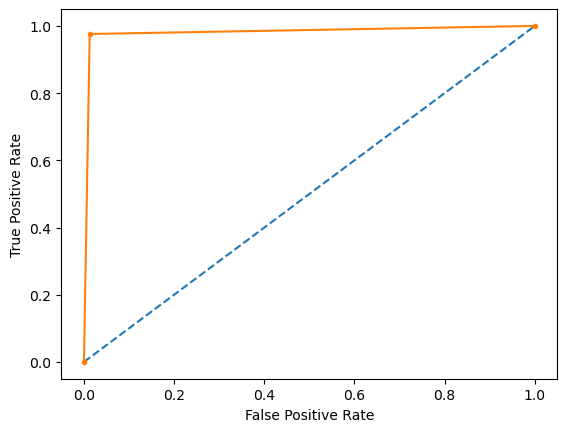

In [373]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [7],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Best parameters found: {'max_depth': 5, 'n_estimators': 22}
Best score found: 0.9820419544771127
 macro f1 = 0.8305634258706581
Test Cost :  6530
[[15272   353]
 [    6   369]]
(16000,)
(16000,)


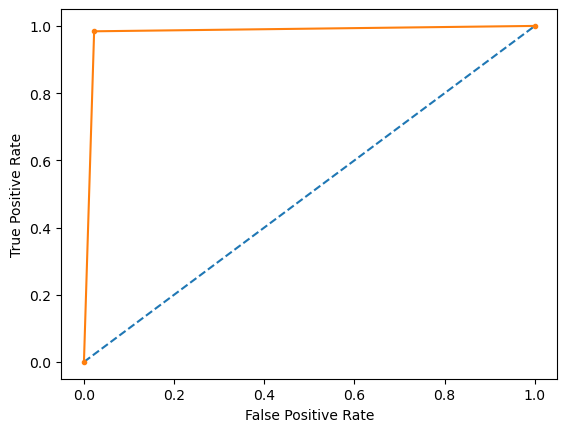

In [374]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [5],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Best parameters found: {'max_depth': 5, 'n_estimators': 22}
Best score found: 0.9823301194260378
 macro f1 = 0.8400699645733294
Test Cost :  5280
[[15297   328]
 [    4   371]]
(16000,)
(16000,)


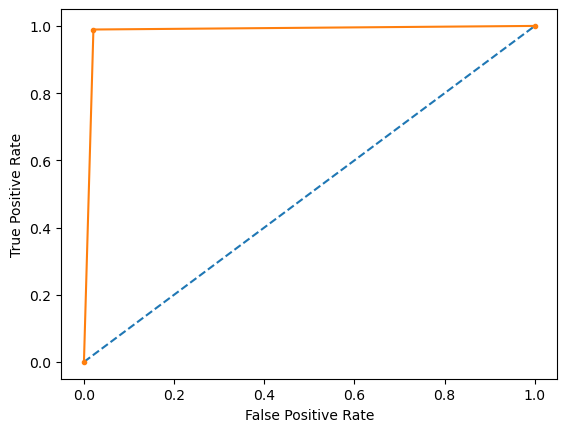

In [375]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5})

# hp tuning
param_grid = {
    'max_depth': [5],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()